Dataset dimensions: (40, 322)
Target distribution: {1: 20, 0: 20}
Generated 100 topological features

=== Univariate Feature Selection (Top 5 Features) ===
UFS Top 5 Features: ['delta44', 'delta45', 'gamma36', 'gamma43', 'delta_temporal_min']
UFS Accuracy (GradientBoost): 0.7500 (±0.0791)
UFS Accuracy (RandomForest): 0.6250 (±0.1118)
UFS Accuracy (SVM): 0.4500 (±0.0612)
Best UFS Classifier: GradientBoost with accuracy 0.7500

=== Recursive Feature Elimination (Top 5 Features) ===
RFE Top 5 Features: ['beta23', 'delta1', 'delta47', 'delta_temporal_std', 'gamma_occipital_std']
RFE Accuracy (GradientBoost): 0.7000 (±0.1500)
RFE Accuracy (RandomForest): 0.6000 (±0.0935)
RFE Accuracy (SVM): 0.5250 (±0.0935)
Best RFE Classifier: GradientBoost with accuracy 0.7000

=== Principal Component Analysis (5 Components) ===
PCA Top 5 Most Influential Features: ['delta_occipital_max', 'delta_occipital_std', 'delta27', 'alpha_central_mean', 'alpha18']
Variance explained by 5 components: 0.8029
PCA Accu

<ipython-input-2-f498bb4c4f2f>:209: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=methods, y=accuracies, palette=bar_colors)
<ipython-input-2-f498bb4c4f2f>:209: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.barplot(x=methods, y=accuracies, palette=bar_colors)


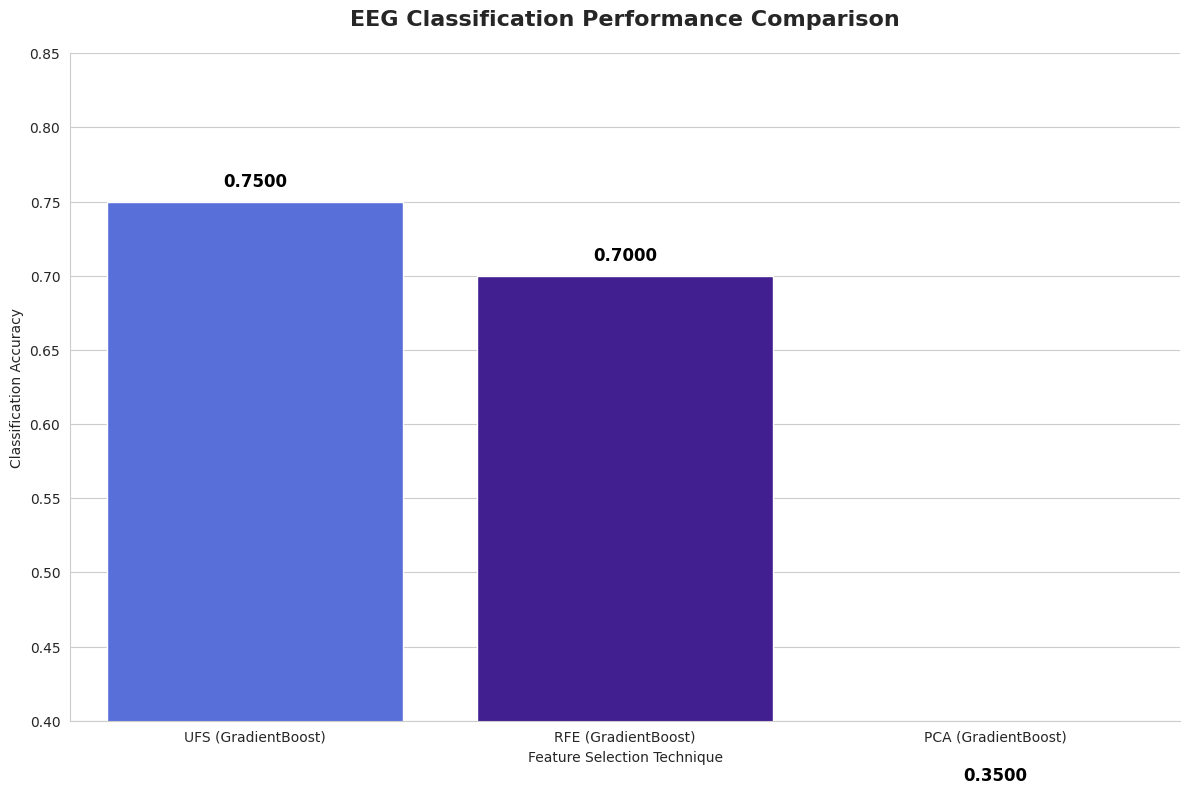

<Figure size 1500x1000 with 0 Axes>

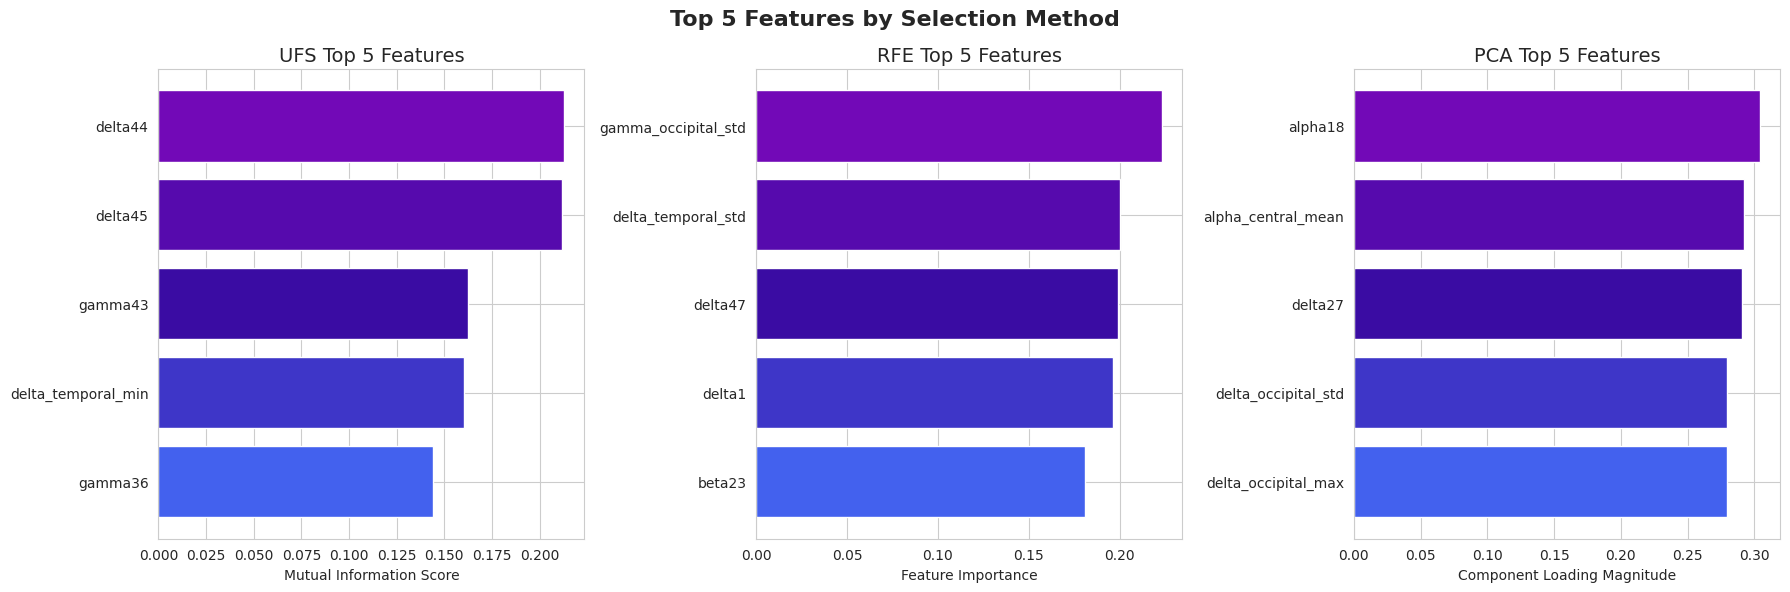


=== Common Features Across Methods ===
No common features found across methods


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from matplotlib.colors import LinearSegmentedColormap

brain_data = pd.read_csv('/eeg data.csv')

print(f"Dataset dimensions: {brain_data.shape}")
print(f"Target distribution: {brain_data.iloc[:, -1].value_counts().to_dict()}")

X_raw = brain_data.iloc[:, 1:-1]
y_target = brain_data.iloc[:, -1]

electrode_groups = {
    'frontal': [1, 2, 3, 9, 10, 11, 12, 13, 14, 18, 19],
    'central': [4, 5, 6, 7, 16, 17, 54, 55],
    'parietal': [31, 32, 35, 36, 37, 38, 39, 40],
    'temporal': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 57, 58, 59],
    'occipital': [33, 34, 51, 52, 53, 56]
}

frequency_bands = {
    'alpha': [col for col in X_raw.columns if col.startswith('alpha')],
    'beta': [col for col in X_raw.columns if col.startswith('beta')],
    'delta': [col for col in X_raw.columns if col.startswith('delta')],
    'theta': [col for col in X_raw.columns if col.startswith('theta')],
    'gamma': [col for col in X_raw.columns if col.startswith('gamma')]
}

def extract_regional_features():
    features_container = {}

    for band_name, band_cols in frequency_bands.items():
        band_data = X_raw[band_cols]

        for region_name, electrode_indices in electrode_groups.items():
            valid_idx = [i-1 for i in electrode_indices if i <= len(band_cols)]
            if not valid_idx:
                continue

            region_data = band_data.iloc[:, valid_idx]

            features_container[f"{band_name}_{region_name}_mean"] = region_data.mean(axis=1)
            features_container[f"{band_name}_{region_name}_std"] = region_data.std(axis=1)
            features_container[f"{band_name}_{region_name}_max"] = region_data.max(axis=1)
            features_container[f"{band_name}_{region_name}_min"] = region_data.min(axis=1)

    return pd.DataFrame(features_container)

derived_features = extract_regional_features()
print(f"Generated {derived_features.shape[1]} topological features")

X_augmented = pd.concat([X_raw, derived_features], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_augmented)

cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

gb_classifier = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    random_state=42
)

svm_classifier = SVC(
    C=10,
    kernel='rbf',
    gamma='scale',
    probability=True,
    random_state=42
)

print("\n=== Univariate Feature Selection (Top 5 Features) ===")

ufs_selector = SelectKBest(mutual_info_classif, k=5)
X_ufs = ufs_selector.fit_transform(X_scaled, y_target)

ufs_indices = ufs_selector.get_support(indices=True)
ufs_top5_features = X_augmented.columns[ufs_indices].tolist()
print(f"UFS Top 5 Features: {ufs_top5_features}")

gb_scores_ufs = cross_val_score(gb_classifier, X_ufs, y_target, cv=cv_splitter)
rf_scores_ufs = cross_val_score(rf_classifier, X_ufs, y_target, cv=cv_splitter)
svm_scores_ufs = cross_val_score(svm_classifier, X_ufs, y_target, cv=cv_splitter)

print(f"UFS Accuracy (GradientBoost): {gb_scores_ufs.mean():.4f} (±{gb_scores_ufs.std():.4f})")
print(f"UFS Accuracy (RandomForest): {rf_scores_ufs.mean():.4f} (±{rf_scores_ufs.std():.4f})")
print(f"UFS Accuracy (SVM): {svm_scores_ufs.mean():.4f} (±{svm_scores_ufs.std():.4f})")

ufs_accuracies = {
    "GradientBoost": gb_scores_ufs.mean(),
    "RandomForest": rf_scores_ufs.mean(),
    "SVM": svm_scores_ufs.mean()
}
ufs_best_clf = max(ufs_accuracies, key=ufs_accuracies.get)
ufs_best_accuracy = ufs_accuracies[ufs_best_clf]
print(f"Best UFS Classifier: {ufs_best_clf} with accuracy {ufs_best_accuracy:.4f}")

print("\n=== Recursive Feature Elimination (Top 5 Features) ===")

rfe_selector = RFE(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    n_features_to_select=5,
    step=2
)
X_rfe = rfe_selector.fit_transform(X_scaled, y_target)

rfe_indices = np.where(rfe_selector.support_)[0]
rfe_top5_features = X_augmented.columns[rfe_indices].tolist()
print(f"RFE Top 5 Features: {rfe_top5_features}")

gb_scores_rfe = cross_val_score(gb_classifier, X_rfe, y_target, cv=cv_splitter)
rf_scores_rfe = cross_val_score(rf_classifier, X_rfe, y_target, cv=cv_splitter)
svm_scores_rfe = cross_val_score(svm_classifier, X_rfe, y_target, cv=cv_splitter)

print(f"RFE Accuracy (GradientBoost): {gb_scores_rfe.mean():.4f} (±{gb_scores_rfe.std():.4f})")
print(f"RFE Accuracy (RandomForest): {rf_scores_rfe.mean():.4f} (±{rf_scores_rfe.std():.4f})")
print(f"RFE Accuracy (SVM): {svm_scores_rfe.mean():.4f} (±{svm_scores_rfe.std():.4f})")

rfe_accuracies = {
    "GradientBoost": gb_scores_rfe.mean(),
    "RandomForest": rf_scores_rfe.mean(),
    "SVM": svm_scores_rfe.mean()
}
rfe_best_clf = max(rfe_accuracies, key=rfe_accuracies.get)
rfe_best_accuracy = rfe_accuracies[rfe_best_clf]
print(f"Best RFE Classifier: {rfe_best_clf} with accuracy {rfe_best_accuracy:.4f}")

print("\n=== Principal Component Analysis (5 Components) ===")

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

feature_importance = np.abs(pca.components_)
feature_importance_sum = np.sum(feature_importance, axis=0)
pca_top5_indices = np.argsort(feature_importance_sum)[-5:]
pca_top5_features = X_augmented.columns[pca_top5_indices].tolist()

variance_explained = sum(pca.explained_variance_ratio_)
print(f"PCA Top 5 Most Influential Features: {pca_top5_features}")
print(f"Variance explained by 5 components: {variance_explained:.4f}")

gb_scores_pca = cross_val_score(gb_classifier, X_pca, y_target, cv=cv_splitter)
rf_scores_pca = cross_val_score(rf_classifier, X_pca, y_target, cv=cv_splitter)
svm_scores_pca = cross_val_score(svm_classifier, X_pca, y_target, cv=cv_splitter)

print(f"PCA Accuracy (GradientBoost): {gb_scores_pca.mean():.4f} (±{gb_scores_pca.std():.4f})")
print(f"PCA Accuracy (RandomForest): {rf_scores_pca.mean():.4f} (±{rf_scores_pca.std():.4f})")
print(f"PCA Accuracy (SVM): {svm_scores_pca.mean():.4f} (±{svm_scores_pca.std():.4f})")

pca_accuracies = {
    "GradientBoost": gb_scores_pca.mean(),
    "RandomForest": rf_scores_pca.mean(),
    "SVM": svm_scores_pca.mean()
}
pca_best_clf = max(pca_accuracies, key=pca_accuracies.get)
pca_best_accuracy = pca_accuracies[pca_best_clf]
print(f"Best PCA Classifier: {pca_best_clf} with accuracy {pca_best_accuracy:.4f}")

print("\n=== Results Summary ===")
method_results = {
    f"UFS ({ufs_best_clf})": ufs_best_accuracy,
    f"RFE ({rfe_best_clf})": rfe_best_accuracy,
    f"PCA ({pca_best_clf})": pca_best_accuracy
}

best_method = max(method_results, key=method_results.get)
best_accuracy = method_results[best_method]

print(f"Best method: {best_method} with accuracy: {best_accuracy:.4f}")

print("\nRanked performance:")
for method, accuracy in sorted(method_results.items(), key=lambda x: x[1], reverse=True):
    print(f"{method}: {accuracy:.4f}")

print("\n=== Top 5 Features Summary ===")
print(f"UFS Top 5 Features: {ufs_top5_features}")
print(f"RFE Top 5 Features: {rfe_top5_features}")
print(f"PCA Top 5 Features: {pca_top5_features}")

sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

methods = list(method_results.keys())
accuracies = list(method_results.values())

custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", ["#4361EE", "#3A0CA3", "#7209B7"])
bar_colors = custom_cmap(np.linspace(0, 1, len(methods)))

ax = sns.barplot(x=methods, y=accuracies, palette=bar_colors)
ax.set(xlabel='Feature Selection Technique', ylabel='Classification Accuracy')
plt.title('EEG Classification Performance Comparison', fontsize=16, fontweight='bold', pad=20)
plt.ylim(0.4, 0.85)

for i, bar in enumerate(ax.patches):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.01,
        f'{accuracies[i]:.4f}',
        ha='center',
        fontweight='bold',
        fontsize=12,
        color='black'
    )

sns.despine(left=False, bottom=False)
plt.tight_layout()
plt.savefig('eeg_classification_results.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(15, 10))

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Top 5 Features by Selection Method', fontsize=16, fontweight='bold')

axes[0].set_title('UFS Top 5 Features', fontsize=14)
ufs_importance = ufs_selector.scores_[ufs_indices]
ufs_sorted_idx = np.argsort(ufs_importance)
axes[0].barh(
    np.array(ufs_top5_features)[ufs_sorted_idx],
    ufs_importance[ufs_sorted_idx],
    color=custom_cmap(np.linspace(0, 1, 5))
)
axes[0].set_xlabel('Mutual Information Score')

axes[1].set_title('RFE Top 5 Features', fontsize=14)
temp_rf = RandomForestClassifier(n_estimators=100, random_state=42)
temp_rf.fit(X_rfe, y_target)
rfe_importance = temp_rf.feature_importances_
rfe_sorted_idx = np.argsort(rfe_importance)
axes[1].barh(
    np.array(rfe_top5_features)[rfe_sorted_idx],
    rfe_importance[rfe_sorted_idx],
    color=custom_cmap(np.linspace(0, 1, 5))
)
axes[1].set_xlabel('Feature Importance')

axes[2].set_title('PCA Top 5 Features', fontsize=14)
pca_importance = feature_importance_sum[pca_top5_indices]
pca_sorted_idx = np.argsort(pca_importance)
axes[2].barh(
    np.array(pca_top5_features)[pca_sorted_idx],
    pca_importance[pca_sorted_idx],
    color=custom_cmap(np.linspace(0, 1, 5))
)
axes[2].set_xlabel('Component Loading Magnitude')

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.savefig('eeg_top5_features.png', dpi=300, bbox_inches='tight')
plt.show()

all_features = set(ufs_top5_features + rfe_top5_features + pca_top5_features)
common_features = {}

for feature in all_features:
    methods = []
    if feature in ufs_top5_features:
        methods.append("UFS")
    if feature in rfe_top5_features:
        methods.append("RFE")
    if feature in pca_top5_features:
        methods.append("PCA")

    if len(methods) > 1:
        common_features[feature] = methods

print("\n=== Common Features Across Methods ===")
if common_features:
    for feature, methods in common_features.items():
        print(f"{feature}: Found in {', '.join(methods)}")
else:
    print("No common features found across methods")